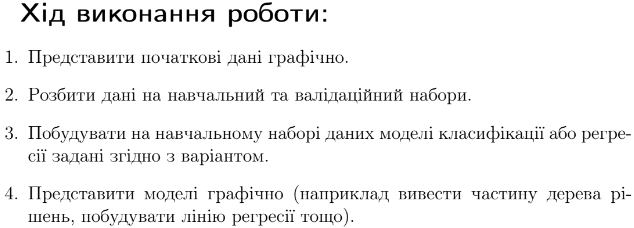

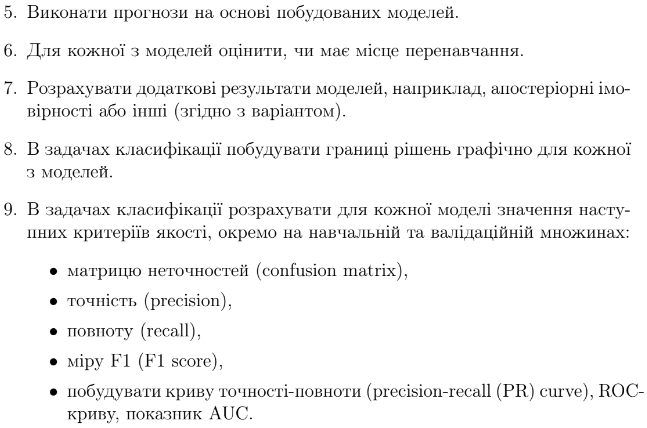

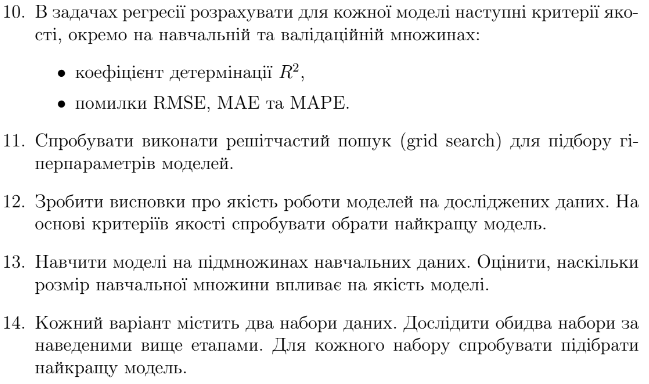

## Варіант 12 завдання:

Побудувати моделi регресiї на основi методу опорних векторiв:

- Моделi нелiнiйної регресiї SVR(kernel="poly") з полiномiальним ядром. Розглянути полiноми рiзного ступеня degree та рiзнi комбiнацiї гiперпараметрiв epsilon i C, наприклад: epsilon=0.1 i C=0.01; epsilon=0.1 i C=100.

- Настроїти гiперпараметри epsilon i C, використовуючи решiтчастий пошук.

## Виконання:

# 1. Shanghai license plate price

In [1]:
import pandas as pd

data = pd.read_csv("data.csv")
data.head()

,Date,Total number of license issued,lowest price,avg price,Total number of applicants
0,Jan-02,1400,13600,14735,3718
1,Feb-02,1800,13100,14057,4590
2,Mar-02,2000,14300,14662,5190
3,Apr-02,2300,16000,16334,4806
4,May-02,2350,17800,18357,4665


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Date                            204 non-null    object
 1   Total number of license issued  204 non-null    int64 
 2   lowest price                    204 non-null    int64 
 3   avg price                       204 non-null    int64 
 4   Total number of applicants      204 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 8.1+ KB


In [38]:
data.describe()

,Total number of license issued,lowest price,avg price,Total number of applicants
count,204.000000,204.000000,204.000000,204.000000
mean,7634.323529,53375.000000,54358.044118,66769.436275
std,2615.136371,24577.035068,23772.554894,85081.873379
min,1400.000000,8100.000000,14057.000000,3525.000000
25%,5958.250000,34050.000000,34932.000000,10457.250000
50%,7876.500000,45050.000000,46036.500000,19324.000000
75%,9000.000000,77950.000000,78142.000000,115978.250000
max,16000.000000,93500.000000,93540.000000,277889.000000


## Початкові дані графічно

Зобразимо гістограми розподілів числових атрибутів:

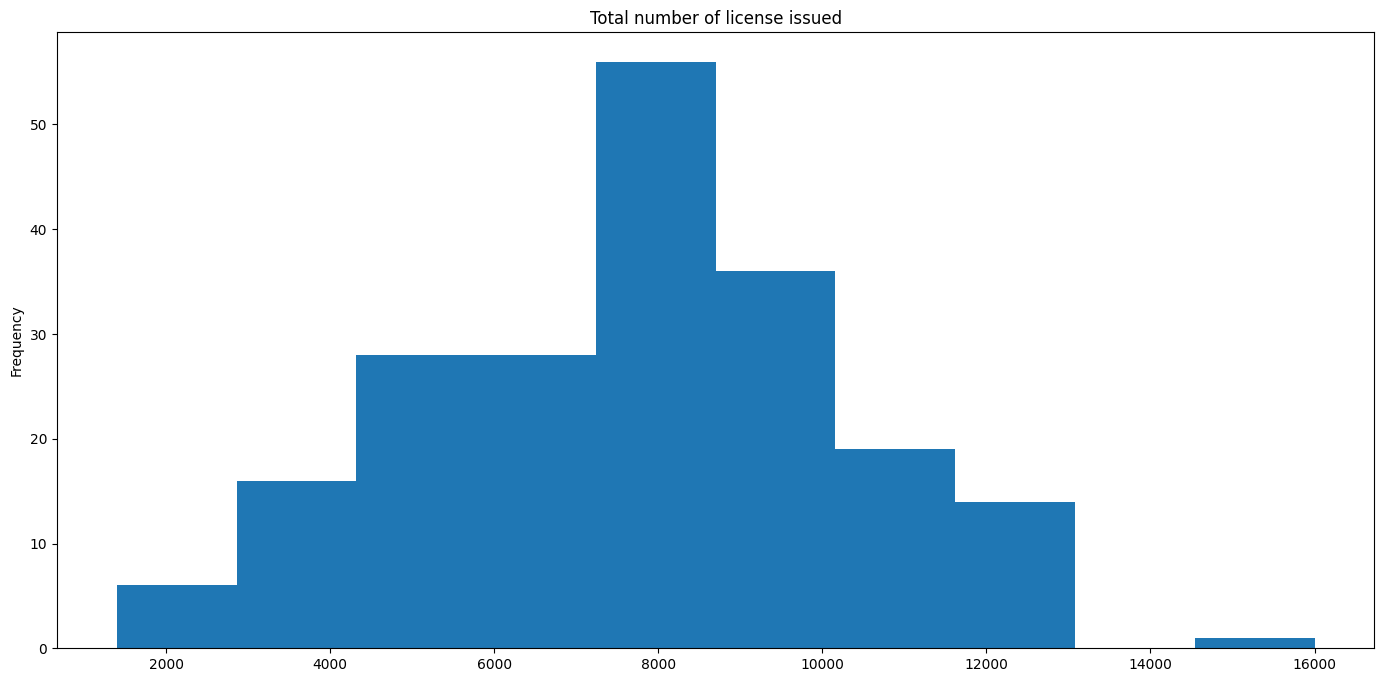

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(17,8))
data["Total number of license issued"].plot(kind = "hist");
plt.title("Total number of license issued");

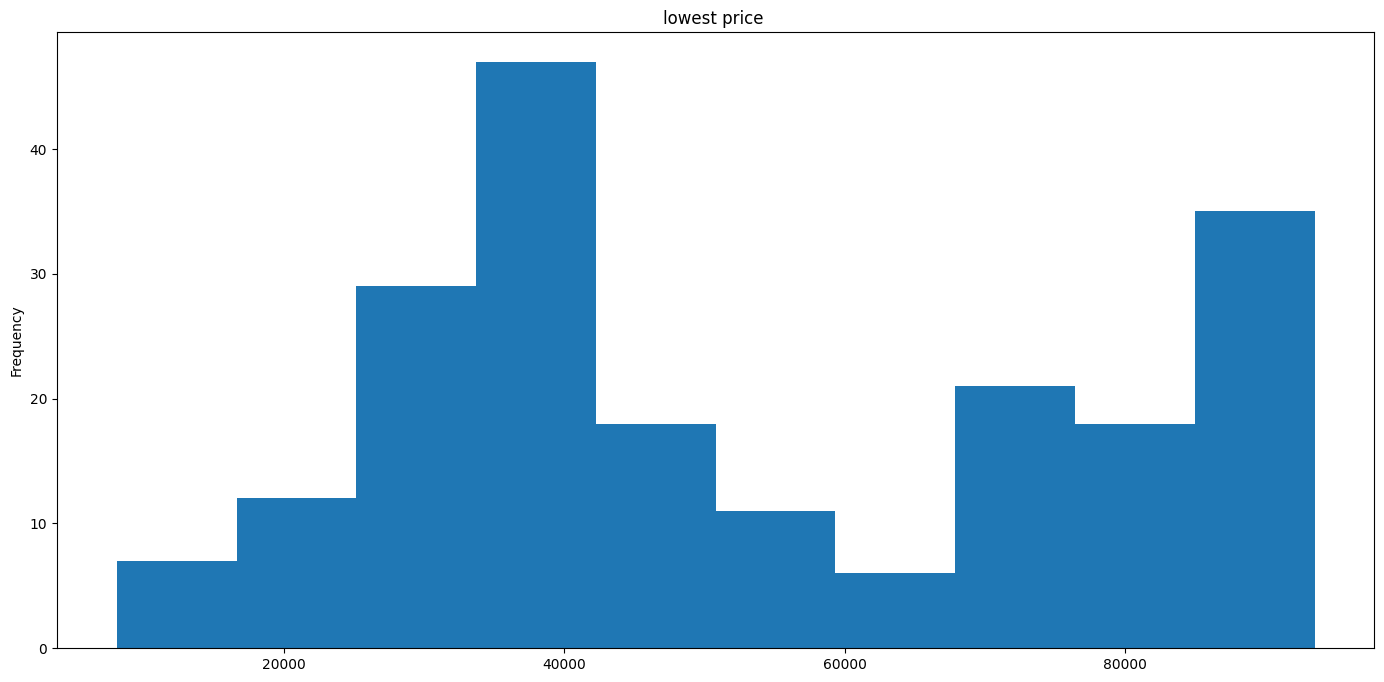

In [40]:
plt.figure(figsize=(17,8))
data["lowest price "].plot(kind = "hist");
plt.title("lowest price ");

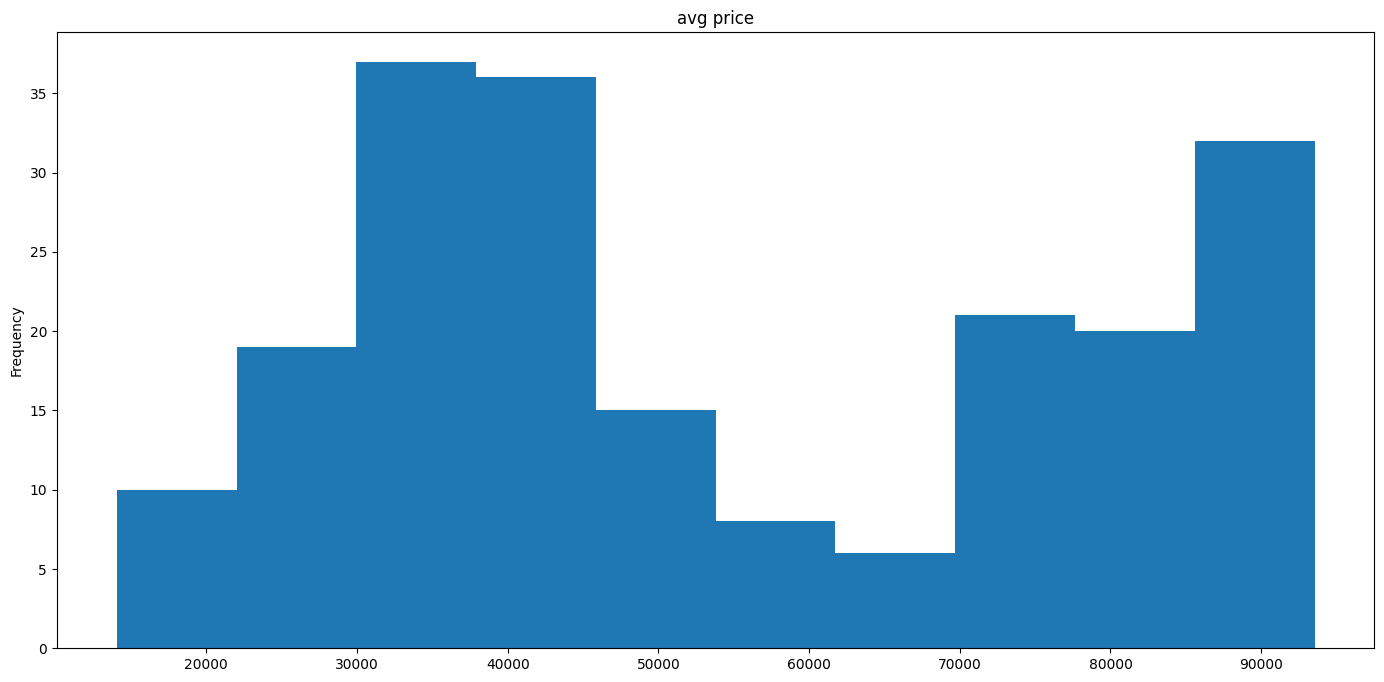

In [41]:
plt.figure(figsize=(17,8))
data["avg price"].plot(kind = "hist");
plt.title("avg price");

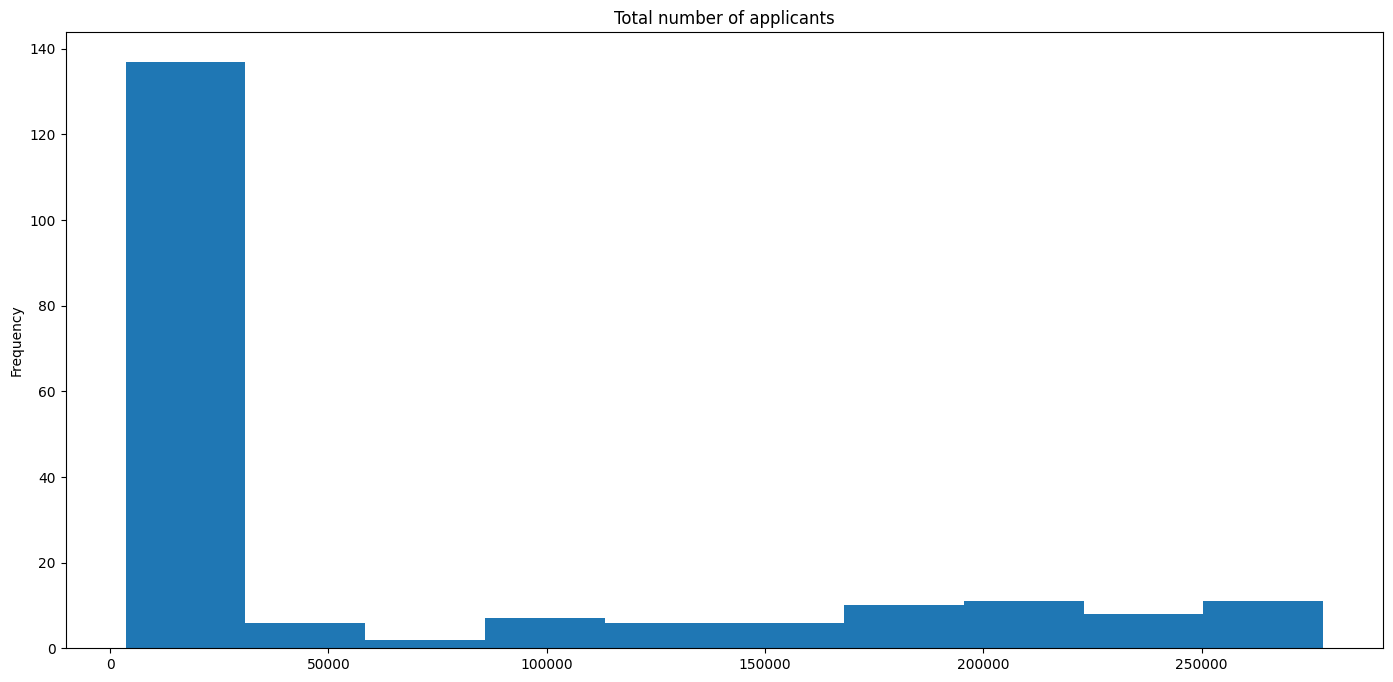

In [42]:
plt.figure(figsize=(17,8))
data["Total number of applicants"].plot(kind = "hist");
plt.title("Total number of applicants");

Також побудуємо scatter_matrix, а також кореляційну матрицю

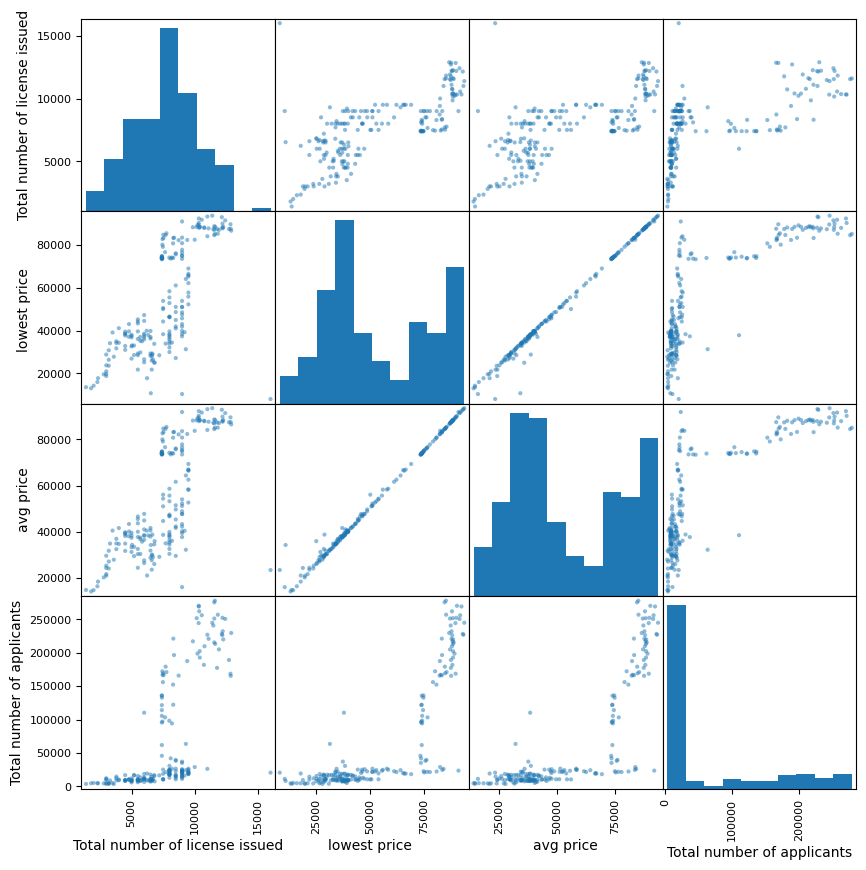

In [43]:
from pandas.plotting import scatter_matrix

scatter_matrix(data, figsize = (10, 10));

In [44]:
data.corr()

,Total number of license issued,lowest price,avg price,Total number of applicants
Total number of license issued,1.000000,0.720451,0.738741,0.649152
lowest price,0.720451,1.000000,0.995960,0.814285
avg price,0.738741,0.995960,1.000000,0.817585
Total number of applicants,0.649152,0.814285,0.817585,1.000000


Бачимо дуже сильну лінійну залежність між цільовим атрибутом avg price та lowest price. Як би в завданні не було потрібно використовувати лише SVR(kernel = "poly"), то можна було б навчити однофакторну лінійну регресійну модель, де відкликом є avg price, а фактором - lowest price 

## Препроцесінг та розбиття датасету на навчальний та валідаційний набори

Опис даних з каглу:

Шанхай використовує систему аукціонів для продажу обмеженої кількості номерних знаків покупцям автомобілів на викопному паливі щомісяця. Середня ціна цього номерного знаку становить близько 13 000 доларів, і його часто називають "найдорожчим шматком металу у світі". Отже, наша мета - спрогнозувати середню ціну або найнижчу ціну на наступний місяць.

In [45]:
data["Date"].value_counts()

Jan-02    1
Oct-13    1
Dec-12    1
Jan-13    1
Feb-13    1
         ..
Nov-07    1
Dec-07    1
Jan-08    1
Mar-08    1
Jan-19    1
Name: Date, Length: 204, dtype: int64

In [46]:
Date = data["Date"].value_counts()
Date.where(Date > 1)

Jan-02   NaN
Oct-13   NaN
Dec-12   NaN
Jan-13   NaN
Feb-13   NaN
          ..
Nov-07   NaN
Dec-07   NaN
Jan-08   NaN
Mar-08   NaN
Jan-19   NaN
Name: Date, Length: 204, dtype: float64

Створимо з даного атрибуту категоріальний, розподіливши його на 4 сезони: зима, весна, літо, осінь. Спочатку залишимо тільки назви місяців:

In [47]:
import warnings

data_copy = data.copy()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(len(data["Date"])):
        data_copy["Date"][i] = data_copy["Date"][i][:3]

data_copy["Date"]

0      Jan
1      Feb
2      Mar
3      Apr
4      May
      ... 
199    Sep
200    Oct
201    Nov
202    Dec
203    Jan
Name: Date, Length: 204, dtype: object

Поміняємо назви місяців на сезони:

In [48]:
import numpy as np

winter_months = ["Dec", "Jan", "Feb"]
spring_months = ["Mar", "Apr", "May"]
summer_months = ["Jun", "Jul", "Aug"]
fall_months   = ["Sep", "Oct", "Nov"]

months = {"winter": winter_months,
          "spring": spring_months,
          "summer": summer_months,
          "fall": fall_months
}

for key in months.keys():
    
    for month in months[key]:
        data_copy["Date"].replace(month, key, inplace = True)

In [49]:
data_copy["Date"].value_counts()

winter    51
spring    51
summer    51
fall      51
Name: Date, dtype: int64

Зробимо невеличкий препроцесінг, стандартизуємо всі атрибути крім цільового(avg_price). Також за допомогою pf.get_dummies() обробимо категоріальний атрибут Date.

In [50]:
from sklearn.preprocessing import StandardScaler

# робота з категоріальним змінними:
data_copy = pd.get_dummies(data_copy)

X = data_copy[['Total number of license issued', 'lowest price ', 'Total number of applicants',
               'Date_fall', 'Date_spring', 'Date_summer', 'Date_winter']]
y = data_copy['avg price'].to_numpy()

#стандартизація:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Тепер можемо розбити набори на навчальний та валідаційний

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42, test_size = 0.2)

## Навчання та прогнози моделей

Зробимо функцію для виведення значень метрик, які були задані в заваданні

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score

def print_metrics(X, y_true, model):
    print('R^2 : ', round(r2_score(y_true, model.predict(X)), 4))
    print('RMSE: ', round(np.sqrt(mean_squared_error(y_true, model.predict(X))), 4))
    print('MAE : ', round(mean_absolute_error(y_true, model.predict(X)), 4))
    print('MAPE: ', round(mean_absolute_percentage_error(y_true, model.predict(X)), 9))

Тепер навчимо модель, яка зазначена в завданні та подивимось на її результати на навчальному наборі:

In [53]:
from sklearn.svm import SVR

svr = SVR(kernel = "poly").fit(X_train, y_train)

print_metrics(X_train, y_train, svr)

R^2 :  -0.1446
RMSE:  25824.6044
MAE :  20984.4017
MAPE:  0.418083488


Бачимо, що модель дала жахливі прогнози навіть на тренувальному наборі. Тепер знайдемо метрики на валідаційному:

In [54]:
print_metrics(X_val, y_val, svr)

R^2 :  -0.2742
RMSE:  24673.5055
MAE :  19977.5334
MAPE:  0.338593623


Метрики R^2, RMSE, MAE на навчальному наборі краще ніж на валідаційному, тому в моделі присутнє перенавчання.

## Підбір гіперпараметрів моделі

Будемо використовувати GridSearchCV, будемо підбирати параметри, які були задані в завданні, а саме: degree, epsilon i C

In [55]:
from sklearn.model_selection import GridSearchCV

param_grid = { "C": [0.001, 0.01, 0.1, 1, 2, 10, 25, 100],
               "degree": [1, 2, 3, 4, 5, 10],
               "epsilon": [1e-4, 0.001, 0.01, 0.1, 1]
}

grid_search = GridSearchCV(estimator = SVR(), param_grid = param_grid)
grid_search.fit(X_train, y_train);
best_estimator = grid_search.best_estimator_

Покажемо найкращі параметри:

In [56]:
best_estimator

SVR(C=100, degree=1, epsilon=0.0001)

## Результати фінальної моделі

In [57]:
print("Навчальний набір:")
print_metrics(X_train, y_train, best_estimator)

print("\nВалідаційний набір:")
print_metrics(X_val, y_val, best_estimator)

Навчальний набір:
R^2 :  -0.0244
RMSE:  24430.5632
MAE :  19846.0426
MAPE:  0.39776623

Валідаційний набір:
R^2 :  -0.1381
RMSE:  23317.8877
MAE :  18903.1672
MAPE:  0.32090509


Навіть після підбору параметрів модель дала жахливі результати, при чому через те що метрики R^2, RMSE, MAE краще на навчальному наборі, в моделі присутнє перенавчання.

## Додатково: краща модель для данного датасету 

Оскільки модель SVR(kernel = "poly") навіть після підбору парметрів дала жахливі результати, то все-таки спробуємо розглянути модель, яку визначали на етапі візуалізації. 

In [58]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression().fit(X_train, y_train)

тепер покажемо результати метрик:

In [59]:
print("Навчальний набір:")
print_metrics(X_train, y_train, lin_reg)

print("\nВалідаційний набір:")
print_metrics(X_val, y_val, lin_reg)

Навчальний набір:
R^2 :  0.992
RMSE:  2154.4132
MAE :  1128.1389
MAPE:  0.029292755

Валідаційний набір:
R^2 :  0.9972
RMSE:  1162.5243
MAE :  935.2286
MAPE:  0.020523485


Як бачимо, результати метрик цієї моделі є набагато кращими за результати попередньої моделі

# 2. avocado prices

In [60]:
data = pd.read_csv("avocado.csv")
data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


In [62]:
data.describe()

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,24.232232,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,15.481045,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.000000,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,10.000000,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,24.000000,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,38.000000,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,52.000000,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


дані про датасет з каглу:

- Date - дата спостереження
- AveragePrice - середня ціна одного авокадо
- type - звичайний або органічний
- year - рік
- Region - місто або регіон спостереження
- Total Volume - загальна кількість проданих авокадо
- 4046 - Загальна кількість проданих авокадо з PLU 4046
- 4225 - Загальна кількість проданих авокадо з PLU 4225
- 4770 - Загальна кількість проданих авокадо з PLU 4770

Будемо передбачати атрибут AveragePrice

Колонки year та Unnamed: 0 приберемо, як не репрезентативні:

In [63]:
data.drop(["Unnamed: 0", "year"], axis = 1, inplace = True)
data.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,Albany


## Початкові дані графічно

Зобразимо гістограми розподілів деяких числових атрибутів:

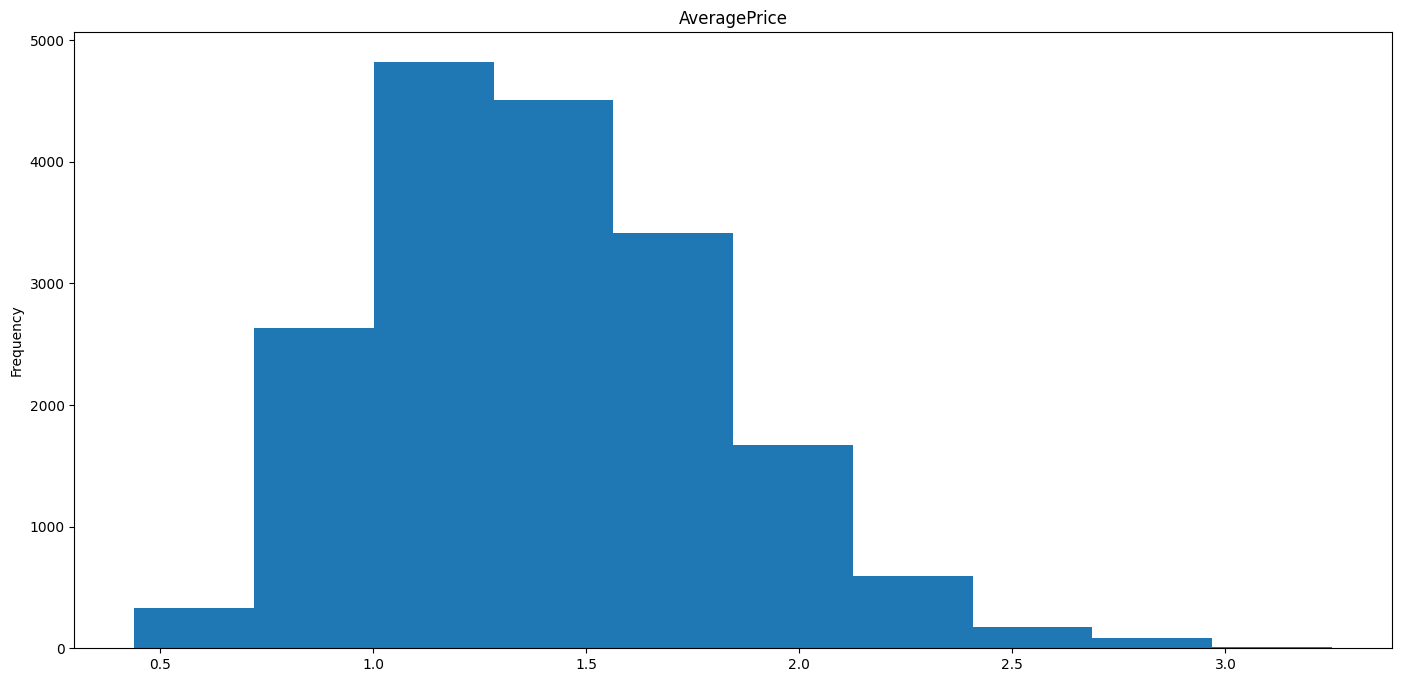

In [64]:
plt.figure(figsize=(17,8))
data["AveragePrice"].plot(kind = "hist");
plt.title("AveragePrice");

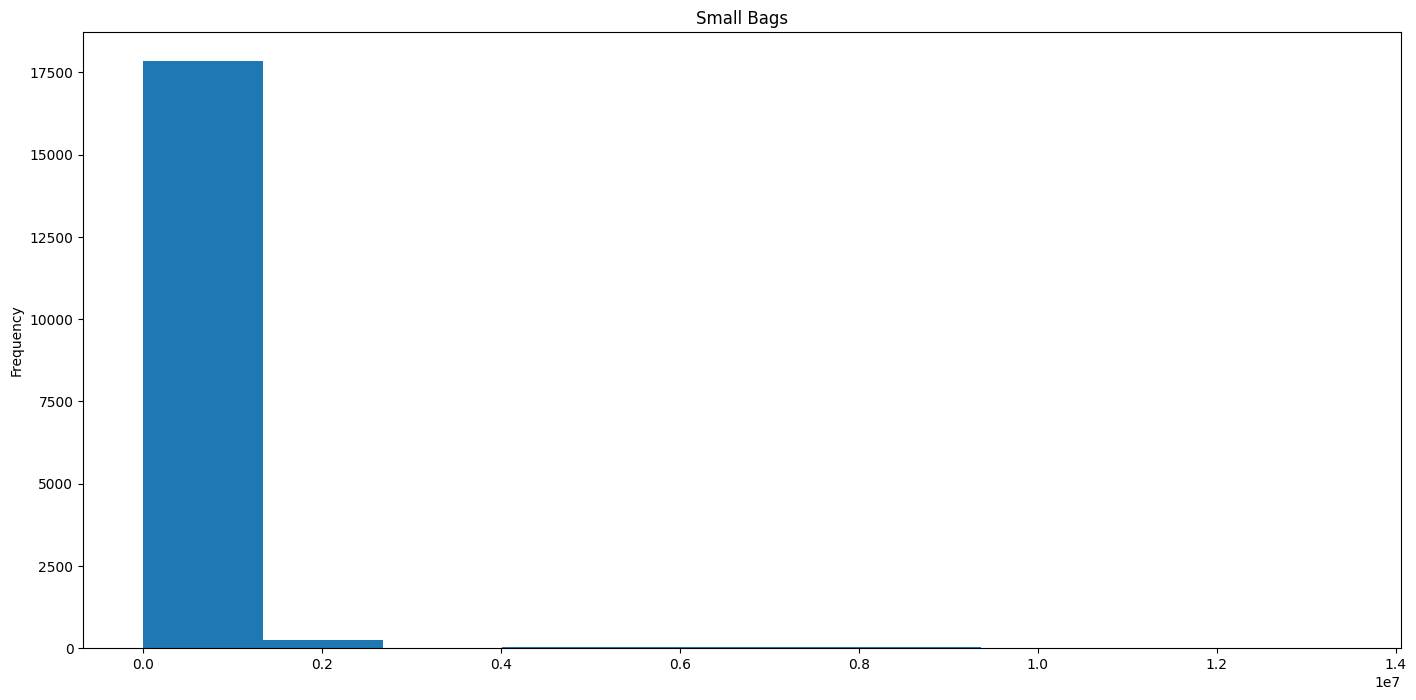

In [65]:
plt.figure(figsize=(17,8))
data["Small Bags"].plot(kind = "hist");
plt.title("Small Bags");

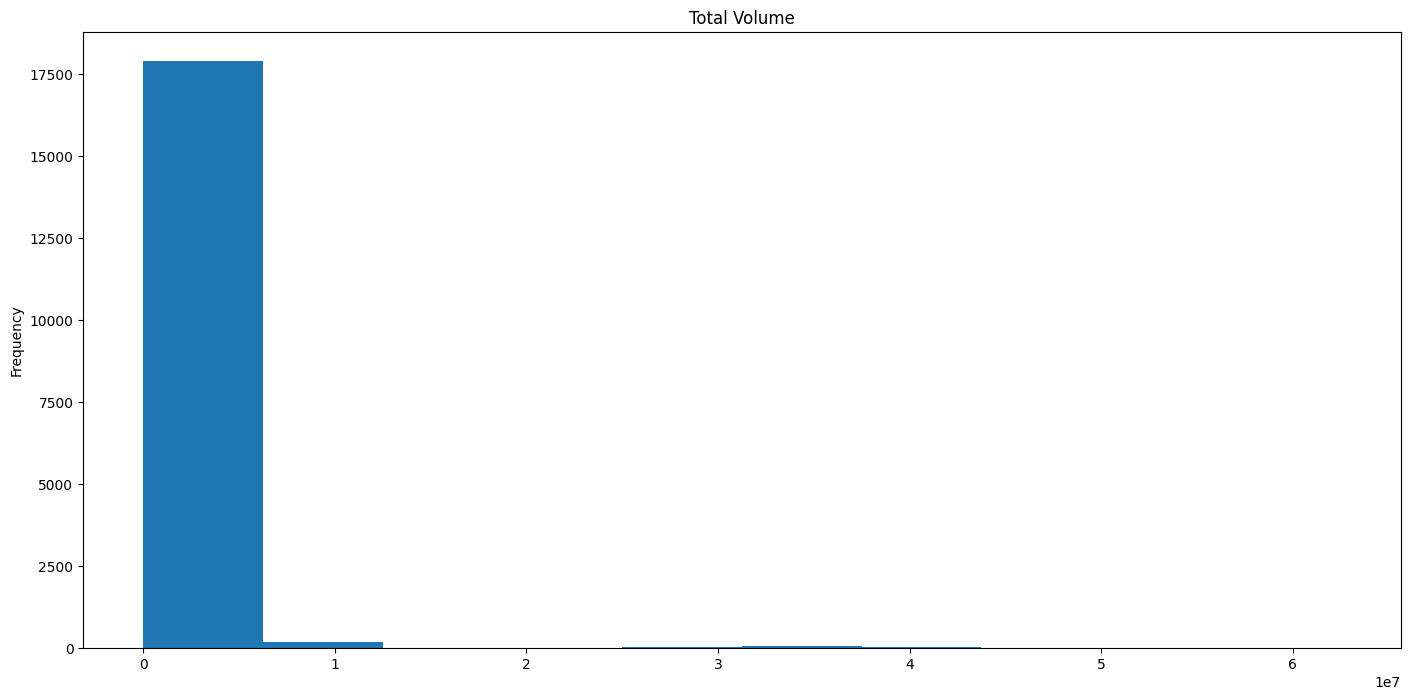

In [66]:
plt.figure(figsize=(17,8))
data["Total Volume"].plot(kind = "hist");
plt.title("Total Volume");

Також побудуємо scatter_matrix, а також кореляційну матрицю

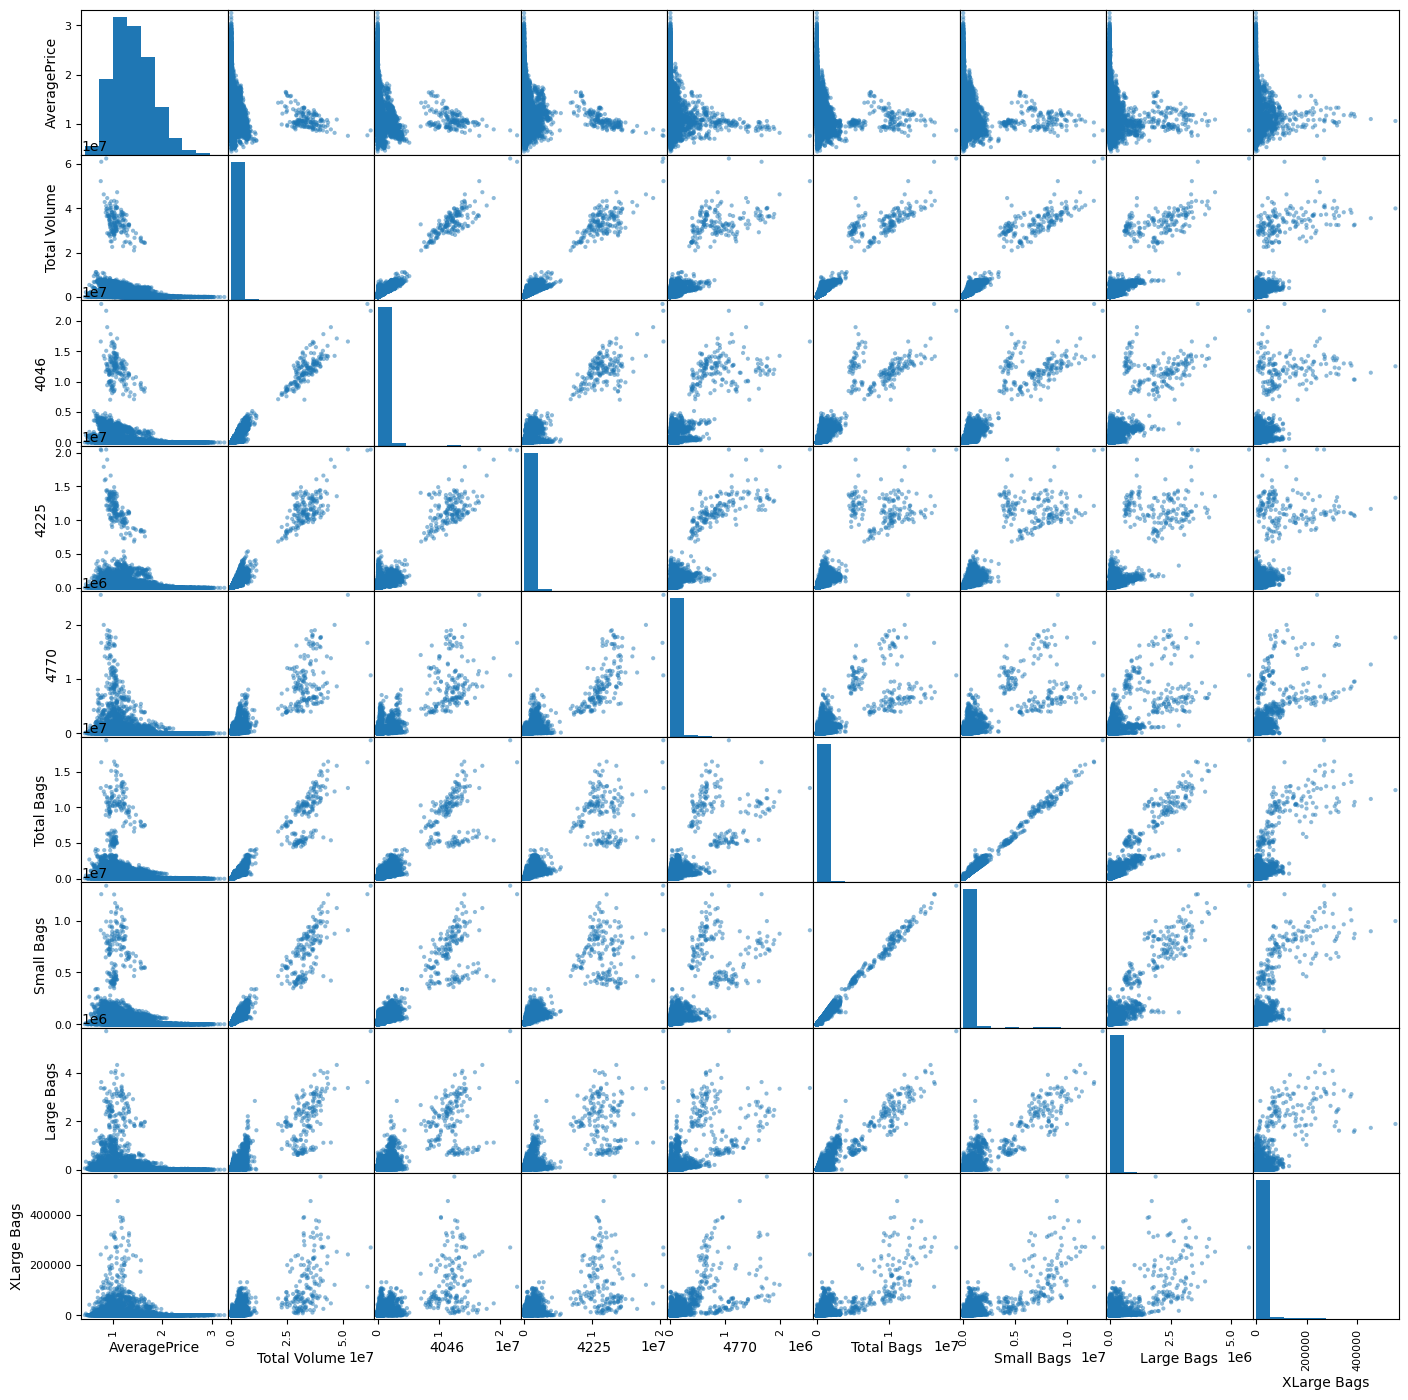

In [67]:
scatter_matrix(data, figsize = (17, 17));

In [68]:
data.corr()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags
AveragePrice,1.000000,-0.192752,-0.208317,-0.172928,-0.179446,-0.177088,-0.174730,-0.172940,-0.117592
Total Volume,-0.192752,1.000000,0.977863,0.974181,0.872202,0.963047,0.967238,0.880640,0.747157
4046,-0.208317,0.977863,1.000000,0.926110,0.833389,0.920057,0.925280,0.838645,0.699377
4225,-0.172928,0.974181,0.926110,1.000000,0.887855,0.905787,0.916031,0.810015,0.688809
4770,-0.179446,0.872202,0.833389,0.887855,1.000000,0.792314,0.802733,0.698471,0.679861
Total Bags,-0.177088,0.963047,0.920057,0.905787,0.792314,1.000000,0.994335,0.943009,0.804233
Small Bags,-0.174730,0.967238,0.925280,0.916031,0.802733,0.994335,1.000000,0.902589,0.806845
Large Bags,-0.172940,0.880640,0.838645,0.810015,0.698471,0.943009,0.902589,1.000000,0.710858
XLarge Bags,-0.117592,0.747157,0.699377,0.688809,0.679861,0.804233,0.806845,0.710858,1.000000


Бачимо дуже сильну лінійну залежність між Small Bags та Total Bags

Покажемо загальну ціну для елементів категоривальних атрибутів type та region

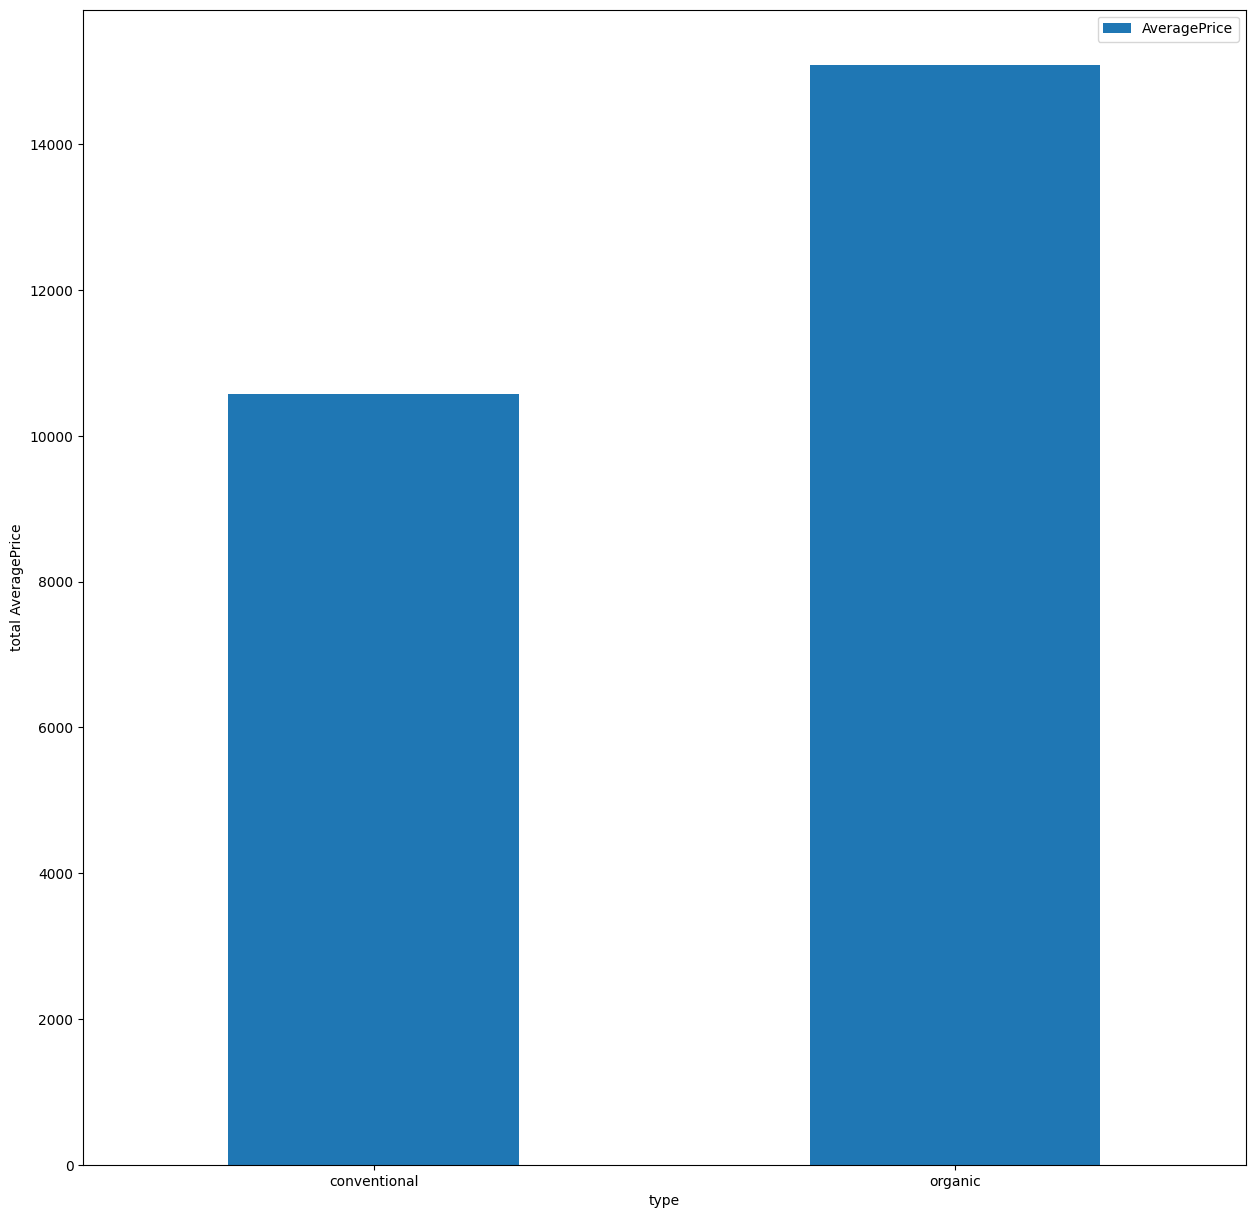

In [69]:
type_info = data[["AveragePrice"] + ["type"]].groupby("type").sum()
type_info.plot(kind = "bar", figsize =(15, 15), rot = 0);
plt.xlabel("type");
plt.ylabel("total AveragePrice");

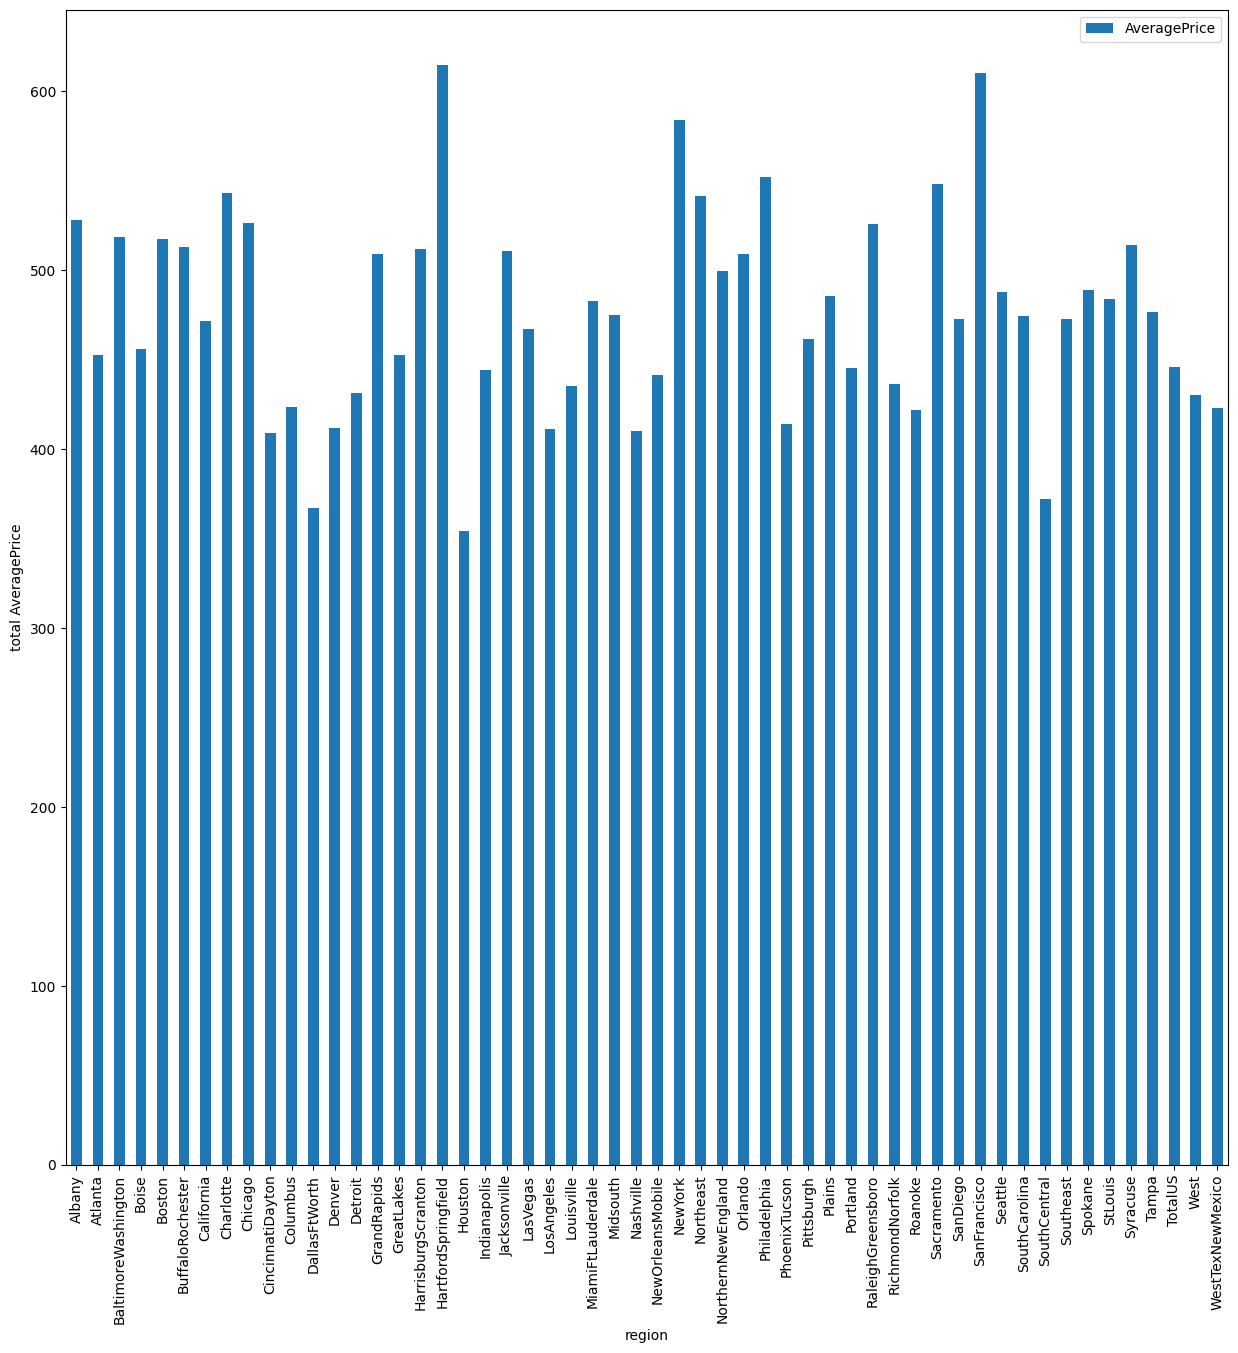

In [70]:
type_info = data[["AveragePrice"] + ["region"]].groupby("region").sum()
type_info.plot(kind = "bar", figsize =(15, 15));
plt.xlabel("region");
plt.ylabel("total AveragePrice");

## Препроцесінг та розбиття датасету на навчальний та валідаційний набори

Обробимо категоріальні змінні та стандартизуємо дані

In [71]:
data_copy = data.copy()
data_copy = pd.get_dummies(data_copy)

not_target_attribs = data_copy.drop("AveragePrice", axis = 1).columns
not_target_attribs = list(not_target_attribs)

scaler = StandardScaler()
X = scaler.fit_transform(data_copy[not_target_attribs])
y = data_copy["AveragePrice"].to_numpy()

розіб'ємо дані на навчальний та валідаційний набори:

In [72]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42, test_size = 0.2)

## Навчання та прогнози моделей

Покажемо результати моделі на навчальному наборі

In [73]:
%%time
svr = SVR(kernel = "poly").fit(X_train, y_train)

print_metrics(X_train, y_train, svr)

R^2 :  0.8865
RMSE:  0.1358
MAE :  0.1025
MAPE:  0.076244347
CPU times: total: 3min 2s
Wall time: 3min 4s


подивимось на її результати на валідаційному наборі:

In [74]:
print_metrics(X_val, y_val, svr)

R^2 :  0.6619
RMSE:  0.2331
MAE :  0.1751
MAPE:  0.130211542


І на навчальному і на валідаційному наборах модель показує непогані результати. Оскільки значення всих метрик краще на навчальному наборі, то присутнє перенавчання.

## Підбір гіперпараметрів моделі

Будемо робити так само як і в попередньому пункті

In [75]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = { "C": [0.001, 0.1],
               "degree": [1, 3, 10],
               "epsilon": [0.001, 0.1, 1]
}

grid_search = GridSearchCV(estimator = SVR(), param_grid = param_grid)
grid_search.fit(X_train, y_train);
best_estimator = grid_search.best_estimator_

CPU times: total: 25min 10s
Wall time: 25min 18s


Покажемо найкращі параметри:

In [76]:
best_estimator

SVR(C=0.1, degree=1, epsilon=0.001)

## Результати фінальної моделі

In [77]:
print("Навчальний набір:")
print_metrics(X_train, y_train, best_estimator)

print("\nВалідаційний набір:")
print_metrics(X_val, y_val, best_estimator)

Навчальний набір:
R^2 :  0.7426
RMSE:  0.2045
MAE :  0.1323
MAPE:  0.095259122

Валідаційний набір:
R^2 :  0.6927
RMSE:  0.2222
MAE :  0.1599
MAPE:  0.115842018


Результати покращились, але невелике перенавчання моделі залишилось. 

# Висновок

Під час виконання даної лабораторної роботи було опрацьовано два датасети. На першому модель SVR(kernel = "poly") дала жахливі результати навіть після підбору параметрів, тому мною, на основі етапу візуалізації даних, була запропонавана інша модель, а саме - однофакторна лінійна регресійна модель яка працює набагато краще попередньої. На другому датасеті була також побудована модель SVR(kernel = "poly"), після чого були підібрані кращі параметри для неї за допомогою решітчатого пошуку.